In [1]:
import pandas as pd
import numpy as np

In [2]:
high_schools = pd.read_csv('../data/full_highschool_data.csv')
high_schools.dropna(subset=['ACT'], inplace=True)

C:\Users\bento\AppData\Local\Temp\ipykernel_4412\2844627415.py:1: DtypeWarning: Columns (804,805,1040,1041,1159,1160,1203) have mixed types. Specify dtype option on import or set low_memory=False.
  high_schools = pd.read_csv('../data/full_highschool_data.csv')


In [3]:
# sort columns by percentage NA
(high_schools.isna().sum()/high_schools.shape[0]).sort_values(ascending=False)

SCH_HBREPORTED_DIS_WH_F       1.0
SCH_DISCWODIS_MULTOOS_AM_M    1.0
SCH_DISCWODIS_MULTOOS_WH_F    1.0
SCH_DISCWODIS_MULTOOS_WH_M    1.0
SCH_DISCWODIS_MULTOOS_BL_F    1.0
                             ... 
TOT_DISCWODIS_EXPZT_F         0.0
TOT_DISCWODIS_EXPZT_M         0.0
SCH_DISCWODIS_EXPZT_TR_F      0.0
SCH_DISCWODIS_EXPZT_TR_M      0.0
ACT                           0.0
Length: 1397, dtype: float64

In [4]:
# drop columns with no data
high_schools = high_schools.dropna(axis=1, how='all')
high_schools.shape

(6918, 914)

In [5]:
# fill in values for missing indicators
high_schools['SCH_FIREARM_IND'].fillna(False, inplace=True)
high_schools['SCH_HOMICIDE_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G09_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G10_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G11_IND'].fillna(False, inplace=True)
high_schools['SCH_SSCLASSES_IND'].fillna(False, inplace=True)
high_schools['SCH_APSEL'].fillna(False, inplace=True)
high_schools['SCH_APMATHENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APSCIENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APOTHENR_IND'].fillna(False, inplace=True)

In [6]:
# fix enrolment for special cases
high_schools[~high_schools['SCH_APENR_IND']].filter(regex=r'.*_AP.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CORPINSTANCES_IND']].filter(regex=r'.*_(DISCWO?DIS|CORPINSTANCES).*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CREDITRECOVERY_IND']].filter(regex=r'.*_CREDITRECOVERY.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_DUAL_IND']].filter(regex=r'.*_DUAL.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_GT_IND']].filter(regex=r'.*_GTENR.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_IBENR_IND']].filter(regex=r'.*_IB.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSCLASSES_IND']].filter(regex=r'.*_SSCLASSES.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSATHLETICS_IND']].filter(regex=r'.*_SS(SPORTS|TEAMS|PART).*',axis=1).fillna(0, inplace=True)

In [7]:
# drop columns with more than 60% na vals
high_schools = high_schools.dropna(axis=1, thresh=int(high_schools.shape[0]*(1-.6)))
high_schools.shape

(6918, 837)

In [8]:
# mark state and district name as a categorical variable
from sklearn.preprocessing import OrdinalEncoder
high_schools['LEA_STATE_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_STATE_NAME'].to_numpy().reshape(-1,1))
high_schools['LEA_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_NAME'].to_numpy().reshape(-1,1))

In [9]:
g = high_schools.columns.to_series().groupby(high_schools.dtypes).groups
high_schools = high_schools.loc[:,~high_schools.columns.isin({k.name: v for k, v in g.items()}['object'])]
X = high_schools.iloc[:,:-1]
X.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1, inplace=True)
y = high_schools['ACT']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
from sklearn.impute import KNNImputer
X_np = KNNImputer().fit_transform(X)
X = pd.DataFrame(X_np, columns=high_schools.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1).iloc[:,:-1].columns)

In [12]:
# replace missing data with either mean or median depending on skewness
# from scipy.stats import skew
#
# for i, col in enumerate(high_schools.columns):
#     if high_schools[col].dtype == object:
#         continue
#     sk = skew(high_schools[col], nan_policy='omit')
#     if abs(sk) > 1:
#         high_schools[col].fillna(high_schools[col].median(), inplace=True)
#     else:
#         high_schools[col].fillna(high_schools[col].mean(), inplace=True)

In [13]:
X.isna().sum()

LEA_STATE_NAME                0
SCH_MATHCLASSES_ADVM          0
SCH_MATHCERT_ADVM             0
SCH_MATHENR_ADVM_HI_M         0
SCH_MATHENR_ADVM_HI_F         0
                             ..
TOT_DISCWDIS_TFRALT_IDEA_F    0
SCH_DISCWDIS_TFRALT_LEP_M     0
SCH_DISCWDIS_TFRALT_LEP_F     0
SCH_DISCWDIS_TFRALT_504_M     0
SCH_DISCWDIS_TFRALT_504_F     0
Length: 830, dtype: int64

In [14]:
X.to_csv('../data/processed_data.csv')

In [15]:
X_all_tot = X.filter(regex=r'^TOT')

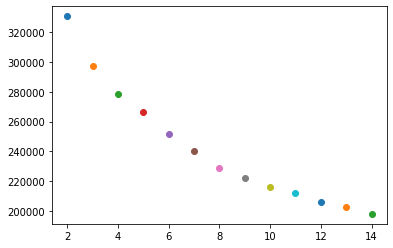

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for k in range(2,15):
    km = KMeans(n_clusters=k).fit(X_all_tot)
    # score = silhouette_score(X, km.labels_)
    plt.scatter(k, km.inertia_)

In [17]:
km = KMeans(n_clusters=5).fit(X_all_tot)

In [18]:
X[km.labels_==0]['LEA_STATE_NAME'].value_counts(),X[km.labels_==1]['LEA_STATE_NAME'].value_counts(),X[km.labels_==2]['LEA_STATE_NAME'].value_counts(),X[km.labels_==3]['LEA_STATE_NAME'].value_counts(),X[km.labels_==4]['LEA_STATE_NAME'].value_counts()

( 0.885209    280
  1.303836    258
 -0.370670    181
 -1.417236    159
  0.257269    158
 -1.626549    144
 -0.789297    110
 -1.835863     99
  0.675896     86
  0.466583     78
 -1.207923     64
 -0.998610     56
  1.094522     53
  0.047956     41
 -0.579983     22
  1.513149     10
 -0.161357      9
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    908
 -0.789297    426
  1.303836    384
 -0.370670    377
  0.047956    346
 -1.207923    234
 -1.835863    231
  0.675896    230
 -0.579983    210
  0.257269    169
 -0.998610    140
 -1.417236    133
  0.466583    120
  1.094522    100
 -0.161357     79
 -1.626549     71
  1.513149     60
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    347
 -1.626549     68
 -1.417236     51
  0.257269     28
 -1.835863     25
 -0.370670     24
  1.094522     20
 -0.998610     18
  0.466583     17
  1.303836     16
  0.047956     15
  0.675896      8
 -0.789297      6
 -0.579983      6
 -1.207923      1
 Name: LEA_STATE_NAME, dtype: int64,
  0.257

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_all_tot,y)
score = lr.score(X_all_tot,y)
score

0.31525156138284427

In [22]:
col_groups= pd.read_excel('../data/2017-18-crdc-data/Documentation/2017-18 CRDC File Structure.xlsx', sheet_name=None)
col_groups.pop('LEA Characteristics')
col_groups.pop('High School Equivalency (GED)')
col_groups.pop('Distance Education')

,Column Finder,Field Name,Field Description
0,A,LEA_STATE,State Abbreviation
1,B,LEA_STATE_NAME,State Name
2,C,LEAID,7 Digit LEAID District Identification Code
3,D,LEA_NAME,District Name
4,E,LEA_ADDRESS,District Address
5,F,LEA_CITY,District City
6,G,LEA_ZIP,District Zip code
7,H,CJJ,"Juvenile Justice Facility (LEA): ""Yes"" indicat..."
8,I,LEA_DISTED_IND,Distance Education Enrollment Indicator (LEA):...
9,J,LEA_DISTEDENR_HI_M,Distance Education Enrollment (LEA): Hispanic...


In [23]:
from sklearn.decomposition import PCA
X_components = np.empty((len(col_groups),X.shape[1]))
means = []
for i, (name, group) in enumerate(col_groups.items()):
    # full_component = np.empty(X.shape[1])
    subset = np.intersect1d(group['Field Name'].iloc[8:], X.columns)
    if len(subset) == 0:
        continue
    pca = PCA(1).fit(X[subset])
    component = pca.components_
    means+=list(pca.mean_)
    X_components[i, list(map(lambda x: X.columns.get_loc(x), subset))] = component

In [24]:
# manually transform principle components
X_reduced = np.dot(X-X.mean(),X_components.T)[:,1:]

i=2, score=0.5280360492675628
i=3, score=0.4255924171583927
i=4, score=0.33484176356790785
i=5, score=0.3355849264184622
i=6, score=0.336290660490012
i=7, score=0.34083774800131234
i=8, score=0.3297205684863202
i=9, score=0.3353080158072862
i=10, score=0.27252933899975973
i=11, score=0.2582846607971323
i=12, score=0.25591638512624443
i=13, score=0.2538598710103249
i=14, score=0.2048183163818312
i=15, score=0.22953236798664486
i=16, score=0.23113364804392944
i=17, score=0.22601754328006424
i=18, score=0.2242248867213759
i=19, score=0.23226237944787342
i=20, score=0.159098351536434
i=21, score=0.1504781281186641
i=22, score=0.1575460521001329
i=23, score=0.1862894993164658
i=24, score=0.14727515549133136
i=25, score=0.15897332501241812
i=26, score=0.15149625526509136
i=27, score=0.14117045441068535
i=28, score=0.14790482770051525
i=29, score=0.10215127918190381
i=30, score=0.17363014301401394
i=31, score=0.16323971695221245
i=32, score=0.14585393723051468
i=33, score=0.16546376898318796


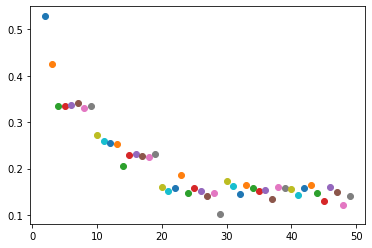

In [25]:
from sklearn.metrics import silhouette_score
wcss = []

for i in range(2,50):
    km = KMeans(i, random_state=0)
    km.fit(X_reduced)
    wcss.append(km.inertia_)
    score = silhouette_score(X_reduced, km.labels_, metric='euclidean')
    plt.scatter(i, score)
    print(f'{i=}, {score=}')

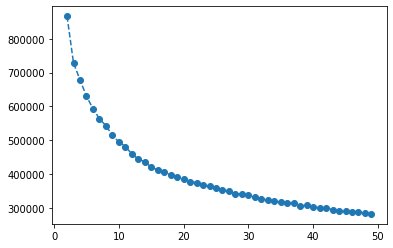

In [26]:
plt.plot(range(2,50), wcss, marker='o', linestyle='--')
plt.show()

In [29]:
for i in set(km.labels_):
    subset = high_schools[km.labels_==i]
    print(f'Cluster {i}, length = {subset.shape[0]}')
    # print(subset['LEA_STATE_NAME'].value_counts())

Cluster 0, length = 162
Cluster 1, length = 99
Cluster 2, length = 150
Cluster 3, length = 1572
Cluster 4, length = 87
Cluster 5, length = 164
Cluster 6, length = 6
Cluster 7, length = 17
Cluster 8, length = 1
Cluster 9, length = 31
Cluster 10, length = 30
Cluster 11, length = 1068
Cluster 12, length = 28
Cluster 13, length = 83
Cluster 14, length = 119
Cluster 15, length = 136
Cluster 16, length = 90
Cluster 17, length = 53
Cluster 18, length = 14
Cluster 19, length = 665
Cluster 20, length = 72
Cluster 21, length = 56
Cluster 22, length = 14
Cluster 23, length = 23
Cluster 24, length = 39
Cluster 25, length = 35
Cluster 26, length = 38
Cluster 27, length = 239
Cluster 28, length = 62
Cluster 29, length = 1
Cluster 30, length = 144
Cluster 31, length = 45
Cluster 32, length = 485
Cluster 33, length = 3
Cluster 34, length = 4
Cluster 35, length = 13
Cluster 36, length = 14
Cluster 37, length = 8
Cluster 38, length = 98
Cluster 39, length = 52
Cluster 40, length = 143
Cluster 41, length

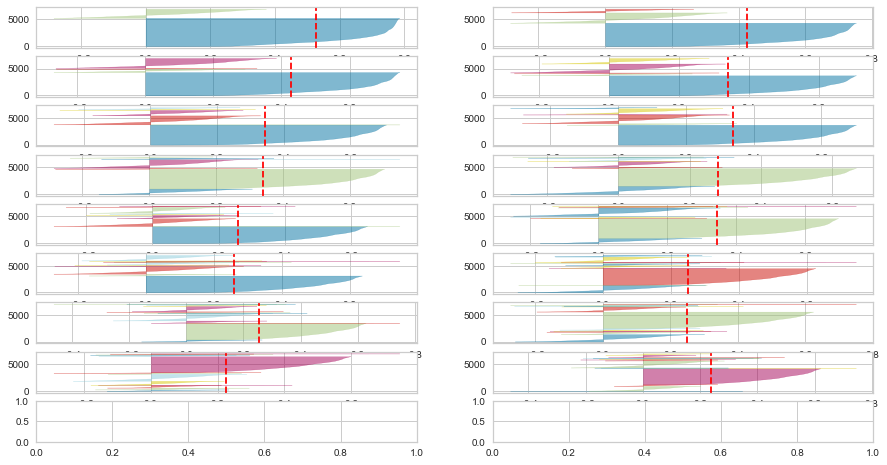

In [30]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(9,2, figsize=(15,8))
for i in range(2,18):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_reduced)

i=2, score=0.46292398848645416
i=3, score=0.4130391268653787
i=4, score=0.41661650088363533
i=5, score=0.4171882240714151
i=6, score=0.4177798195179483
i=7, score=0.21893029432925065
i=8, score=0.2234865137596791
i=9, score=0.22636104620084477
i=10, score=0.22498955800894266
i=11, score=0.2265316101358501
i=12, score=0.2250422084233461
i=13, score=0.2228416315091808
i=14, score=0.21814685561618508
i=15, score=0.22120789730455473
i=16, score=0.221674340222431
i=17, score=0.2228298150250947
i=18, score=0.22949353275698206
i=19, score=0.2303826395507553
i=20, score=0.23057212149562778
i=21, score=0.23135174704416053
i=22, score=0.22790985001978975
i=23, score=0.22934813514087776
i=24, score=0.23030447213486024
i=25, score=0.23103135369691316
i=26, score=0.23125594257624912
i=27, score=0.23164543634556456
i=28, score=0.23265685465201608
i=29, score=0.12573762644997072
i=30, score=0.1199230538427412
i=31, score=0.12271428059213745
i=32, score=0.1211167169595805
i=33, score=0.121617696619420

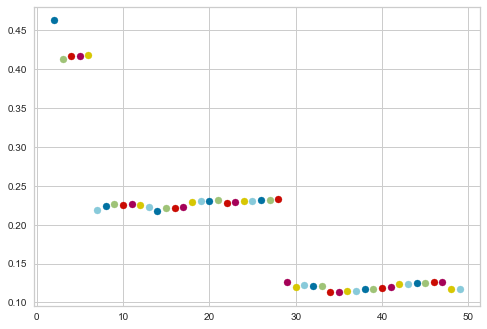

In [33]:
from sklearn.cluster import AgglomerativeClustering
wcss = []

for i in range(2,50):
    ag = AgglomerativeClustering(i)
    ag.fit(X_reduced)
    score = silhouette_score(X_reduced, ag.labels_, metric='euclidean')
    plt.scatter(i, score)
    print(f'{i=}, {score=}')

ep=1, score=0.11789095704571255
ep=2, score=0.11789095704571255
ep=3, score=0.11789095704571255
ep=4, score=0.11789095704571255
ep=5, score=0.11789095704571255
ep=6, score=0.11789095704571255
ep=7, score=0.11789095704571255
ep=8, score=0.11789095704571255
ep=9, score=0.11789095704571255
ep=10, score=0.11789095704571255
ep=11, score=0.11789095704571255
ep=12, score=0.11789095704571255
ep=13, score=0.11789095704571255
ep=14, score=0.11789095704571255
ep=15, score=0.11789095704571255
ep=16, score=0.11789095704571255
ep=17, score=0.11789095704571255
ep=18, score=0.11789095704571255
ep=19, score=0.11789095704571255


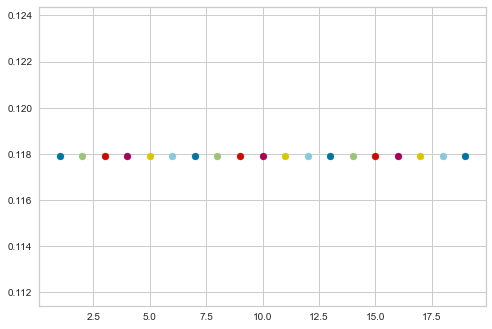

In [40]:
from sklearn.cluster import DBSCAN
for ep in range(1,20):
    db = DBSCAN(ep).fit(X_reduced)
    score = silhouette_score(X_reduced, ag.labels_, metric='euclidean')
    plt.scatter(ep,score)
    print(f'{ep=}, {score=}')

n=2, score=0.44278851997780605
n=3, score=0.39335045179405664
n=4, score=0.38024718438742117
n=5, score=0.38170374372821686
n=6, score=0.38229561111201515
n=7, score=0.384095303776484
n=8, score=0.38781930442317897
n=9, score=0.38883106912613496
n=10, score=0.2013440832360904
n=11, score=0.19973745162638057
n=12, score=0.19312790313164385
n=13, score=0.19635538290888788
n=14, score=0.1971259964078211
n=15, score=0.198514204529681
n=16, score=0.1976379468270907
n=17, score=0.19951920827671393
n=18, score=0.20675839160749446
n=19, score=0.2073710770583096


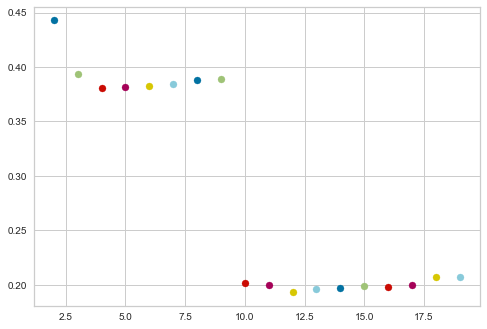

In [41]:
from sklearn.cluster import Birch

for n in range(2,20):
    br = Birch(n_clusters=n).fit(X_reduced)
    score = silhouette_score(X_reduced, br.labels_, metric='euclidean')
    plt.scatter(n,score)
    print(f'{n=}, {score=}')

In [78]:
col_names = ['method','score','Advanced Mathematics','Advanced Placement','Algebra I','Algebra II','Biology','Calculus','Chemistry','Corporal Punishment','Credit Recovery','Dual Enrolment','Enrolment','Expulsions','Geometry','Gifted and Talented','Harassment and Bullying','International Baccalaureate','Offenses','Physics','Referrals and Arrests','Restraint and Seclusion','Retention','SAT and ACT','School Characteristics','School Expenditures','School Support','Single-sex Athletics','Single-sex Classes','Suspensions','Transfers']
rows = []

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_reduced, y)
lr = LinearRegression().fit(X_trainr,y_trainr)
score = lr.score(X_testr, y_testr)
rows.append(['LinearRegression',score,*lr.coef_])
f'R^2 = {score}'

'R^2 = 0.27451025833035325'

In [80]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_trainr, y_trainr)
score = ridge.score(X_testr, y_testr)
rows.append(['Ridge',score,*ridge.coef_])
f'R^2 = {score}'

'R^2 = 0.27451477038346417'

In [81]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0).fit(X_trainr, y_trainr)
score = lasso.score(X_testr, y_testr)
rows.append(['Lasso',score,*lasso.coef_])
f'R^2 = {score}'

'R^2 = 0.15742804774028896'

In [86]:
from sklearn.svm import SVR
svr = SVR(kernel='linear').fit(X_trainr, y_trainr)
score = svr.score(X_testr, y_testr)
rows.append(['SVR',score,*svr.coef_[0]])
f'R^2 = {score}'

'R^2 = 0.26141504376068236'

In [83]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor().fit(X_trainr, y_trainr)
score = dtr.score(X_testr, y_testr)
rows.append(['DTR',score,*([np.nan]*29)])
f'R^2 = {score}'

'R^2 = -0.14778706733286673'

In [84]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(5).fit(X_trainr, y_trainr)
score = knr.score(X_testr, y_testr)
rows.append(['KNR',score,*([np.nan]*29)])
f'R^2 = {score}'

'R^2 = 0.33601863641197116'

In [87]:
component_per_sheet_res = pd.DataFrame(rows, columns=col_names)
component_per_sheet_res

,method,score,Advanced Mathematics,Advanced Placement,Algebra I,Algebra II,Biology,Calculus,Chemistry,Corporal Punishment,...,Restraint and Seclusion,Retention,SAT and ACT,School Characteristics,School Expenditures,School Support,Single-sex Athletics,Single-sex Classes,Suspensions,Transfers
0,LinearRegression,0.274510,0.157625,0.009385,-0.087654,0.036127,0.194237,0.096397,0.072748,-0.134584,...,-2.503106e-307,-0.072295,-0.019057,-0.089848,0.004882,0.164135,0.182542,-0.285489,-1.295596e-311,0.031382
1,Ridge,0.274515,0.157627,0.009383,-0.087637,0.036115,0.194224,0.096387,0.072733,-0.134546,...,-1.614390e-307,-0.072299,-0.019064,-0.089840,0.004884,0.164104,0.182535,-0.285414,-1.613693e-307,0.031378
2,Lasso,0.157428,0.150601,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000e+00,-0.064539,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00,-0.000000
3,SVR,0.261415,"[0.15228026069322187, 0.001502336979907426, -0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTR,-0.147787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KNR,0.336019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SVR,0.261415,0.15228,0.001502,-0.075876,-0.003993,0.205477,0.127275,0.017698,-0.134158,...,-4.673900e-308,-0.155293,-0.015049,-0.124518,0.006631,0.121782,0.237277,-0.267713,-4.670890e-308,0.041112


In [88]:
rows = []
X_traint, X_testt, y_traint, y_testt = train_test_split(X_all_tot, y)
lr = LinearRegression().fit(X_traint,y_traint)
score = lr.score(X_testt, y_testt)
rows.append(['LinearRegression',score,*lr.coef_])
f'R^2 = {score}'

'R^2 = 0.2879110085918293'

In [89]:
ridge = Ridge().fit(X_traint, y_traint)
score = ridge.score(X_testt, y_testt)
rows.append(['Ridge',score,*ridge.coef_])
f'R^2 = {score}'

'R^2 = 0.28860161861356937'

In [90]:
lasso = Lasso(random_state=0).fit(X_traint, y_traint)
score = lasso.score(X_testt, y_testt)
rows.append(['Lasso',score,*lasso.coef_])
f'R^2 = {score}'

'R^2 = -0.0005841513614699423'

In [91]:
svr = SVR(kernel='linear').fit(X_traint, y_traint)
score = svr.score(X_testt, y_testt)
rows.append(['SVR',score,*svr.coef_[0]])
f'R^2 = {score}'

'R^2 = 0.2717678128988611'

In [92]:
dtr = DecisionTreeRegressor().fit(X_traint, y_traint)
score = dtr.score(X_testt, y_testt)
rows.append(['DTR',score,*([np.nan]*29)])
f'R^2 = {score}'

'R^2 = -0.09713409998623579'

In [93]:
knr = KNeighborsRegressor(5).fit(X_traint, y_traint)
score = knr.score(X_testt, y_testt)
rows.append(['KNR',score,*([np.nan]*29)])
f'R^2 = {score}'

'R^2 = 0.3323977133055003'

In [98]:
all_tot_res = pd.DataFrame(rows, columns=['method','score',*X_all_tot.columns])
all_tot_res

,method,score,TOT_MATHENR_ADVM_M,TOT_MATHENR_ADVM_F,TOT_APENR_M,TOT_APENR_F,TOT_APMATHENR_M,TOT_APMATHENR_F,TOT_APSCIENR_M,TOT_APSCIENR_F,...,TOT_RET_G12_F,TOT_SATACT_M,TOT_SATACT_F,TOT_SSSPORTS,TOT_SSTEAMS,TOT_SSPART,TOT_DISCWODIS_TFRALT_M,TOT_DISCWODIS_TFRALT_F,TOT_DISCWDIS_TFRALT_IDEA_M,TOT_DISCWDIS_TFRALT_IDEA_F
0,LinearRegression,0.287911,0.312905,-0.358276,1.071884,-0.171834,0.199782,0.126159,0.201940,-0.136823,...,-0.106080,-0.559292,0.516196,0.292726,-0.041765,0.310495,-0.024345,-0.112191,0.100003,0.044073
1,Ridge,0.288602,0.287117,-0.332785,0.890473,0.011136,0.210623,0.119355,0.211398,-0.141056,...,-0.092416,-0.565986,0.520178,0.291545,-0.041713,0.310833,-0.023306,-0.111591,0.098103,0.044153
2,Lasso,-0.000584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
3,SVR,0.271768,0.218206,-0.276691,0.709097,0.748504,0.278529,0.129051,0.437819,-0.182560,...,0.097136,-0.556015,0.427245,0.340484,-0.047245,0.266481,-0.051136,-0.038049,0.047626,0.051020
4,DTR,-0.097134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KNR,0.332398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
